In [14]:
__author__ = 'Daisuke Yoda'
__Date__ = 'January 2019'

## Loading Modules

In [15]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
__dir__ = os.getcwd()[:-11]

from chainer import Chain, Variable, optimizers, serializers
import chainer.functions as F
import chainer.links as L

from gensim.models.keyedvectors import KeyedVectors

## Functions

In [16]:
def word_to_index(word):
    word_index = [ord (char) - 97 for char in word]
    return word_index


def one_hot_encoding(indices, n_class=27):
    return np.eye(n_class)[indices]

def padding(sentences):
    max_len = np.max([len(s) for s in sentences])
    paded_vec = []
    for sentence in sentences:
        pad_len = max_len - len(sentence)
        pad_vec = [26] * pad_len
        sentence.extend(pad_vec)
        paded_vec.append(sentence)

    return np.array(paded_vec, dtype=np.int32)

## LSTM model

In [17]:
class LSTM(Chain):
    def __init__(self, in_size, hidden_size,out_size):
        super(LSTM, self).__init__(
            h1 = L.NStepLSTM (
                n_layers=1,
                in_size=in_size,
                out_size=hidden_size,
                dropout=0.5),
            atn = L.Linear(hidden_size*17,out_size),
            hy = L.Linear(hidden_size,out_size))


    def __call__(self,input_data,hx=None):
        if np.any(hx):
            hx = hx.reshape(1,-1,self.h1.out_size)
        input_x = [Variable(x) for x in input_data]
        hx,cx,y = self.h1(hx,None,input_x)
        y2 = [F.concat(x, axis=0) for x in F.pad_sequence(y,length=17, padding=0.)]
        y2 = F.concat([F.expand_dims(x,axis=0) for x in y2],axis=0)
        
        out = self.hy(F.concat([F.expand_dims(item[-1],axis=0) for item in y],axis=0))

        atn = self.atn(y2)
        atn = F.softmax(atn)

        return F.concat([F.expand_dims(a*o,axis=0) for a,o in zip(atn,out)],axis=0)

    def predict(self,word,hx=None):
        test_vec = word_to_index(word)
        test_vec = one_hot_encoding(test_vec).astype(np.float32)
        res = self([test_vec],hx)[0]
        return F.argmax(res)


## Original Dataset (Random)
### (words and their split point)

In [18]:
df = pd.read_csv(__dir__ + 'data/split_point_2.csv', index_col=0)
df = df[np.random.permutation (df.columns)]
df.T.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
annual,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
looked,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
afterwards,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
throws,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buying,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Loading the glove data and Using it for all words into glove vectors

In [19]:
word_vectors = KeyedVectors.load_word2vec_format(__dir__ + 'data/glove.6B.200d.bin')
word_vec = np.array([word_vectors.get_vector(word) for word in df.columns], dtype=np.float32)

## Data arrangement

In [20]:
original_data = [word_to_index(x) for x in df.columns]
original_data = [one_hot_encoding(x).astype (np.float32) for x in original_data]
split_point = np.nan_to_num(df, 0).T

trainX = original_data[:1500]
testX = original_data[1500:]

trainY = split_point[:1500].astype(np.float32)
testY = split_point[1500:].astype(np.float32)

## defining the model and set optimizer

In [21]:
model = LSTM(27, 200, 17)
optimizer = optimizers.Adam()
optimizer.setup(model)

## Training

In [22]:
train_loss_record = []
test_loss_record = []
model.train = True   
for i in range(150):
    model.cleargrads()
    res = model(trainX,word_vec[:1500])
    train_loss = F.mean_squared_error(res,trainY)
    train_loss.backward()
    train_loss_record.append(float(train_loss.data))
    optimizer.update()

    res = model(testX,word_vec[1500:])
    test_loss = F.mean_squared_error(res,testY)
    test_loss_record.append(float(test_loss.data))

## Loss at the each epoch

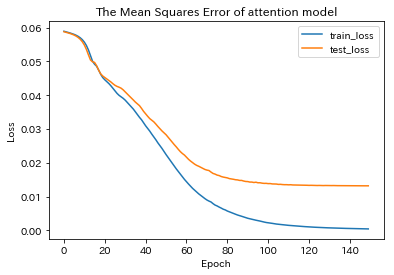

In [23]:
model.train = False

plt.plot(np.array(train_loss_record))
plt.plot(np.array(test_loss_record))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss','test_loss'])
plt.title('The Mean Squares Error of attention model')
plt.show()

In [24]:
train_accuracy = 100*np.sum(np.argmax(model(trainX,word_vec[:1500]).data, axis=1)==np.argmax(trainY,axis=1))/len(trainX)
test_accuracy = 100*np.sum(np.argmax(model(testX,word_vec[1500:]).data, axis=1)==np.argmax(testY,axis=1))/len(testX)

print('train_accuracy:',train_accuracy)
print('test_accuracy:',test_accuracy)


train_accuracy: 99.8
test_accuracy: 85.51336146272855
